In [2]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nptdms import TdmsFile #Process ramping file

#For building ML models
import keras
import keras.models as models
from keras.layers.core import Dense
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import find_peaks

np.random.seed(1337) # for reproducibility


def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time_label(dir_path, time_range, window = 2000, step = 10):
    
    time_label =  np.load(dir_path + "time.npy")
    
    start = min(time_label)
    end = max(time_label)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    time_label = time_label[(time_label > start) & (time_label < end)][window-1::step]
    
    %reset -f in
    
    return time_label

#### Mean of abs(signal)
def generate_mean_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_mean = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_mean

#### SD of signal
def generate_sd_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

#### Thresholded zero crossings
def zero_crossings(array):
    
    #Set values outside of range (0.001, 0.1) = 0
    array[abs(array) > 0.1] = 0
    array[abs(array) < 0.005] = 0
    
    #Calculate number of zero-crossing points, normalized by the window size
    zero_crossings = ((array[:-1] * array[1:]) < 0).sum()/array.size
    
    return zero_crossings


def generate_crossings_data(dir_path, time_range = None, window = 5000, step = 10):
    
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_crossings = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_crossings


def generate_data(dir_path, time_range, window = 2000, thres_win = 25000, step = 10):
    
    #Selection index due to using different window
    selection_index = int((thres_win - window)/step)
    
    moving_mean = generate_mean_data(dir_path, time_range, window = window, step = step)[selection_index:]
    moving_sd = generate_sd_data(dir_path, time_range, window = window, step = step)[selection_index:]
    #moving_thres_crossings = generate_crossings_data(dir_path, time_range, window = thres_win, step = step)
    time_label = load_time_label(dir_path, time_range, window = window, step = step)[selection_index:]
    
    all_data = np.concatenate((moving_mean, moving_sd), axis = 1)
    
    print("All data's shape: ", all_data.shape)
    
    %reset -f in
    
    return all_data, time_label

#####-------INCREMENTAL LEARNING IMPLEMENTATION-------######

def create_model():
    
    #================BUILD THE MODEL====================
    # Simple model
    # Simple model
    model = models.Sequential()

    model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(0.0),
                    input_dim=12))

    model.add(Dense(3,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(6,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(12,
                    kernel_initializer='glorot_uniform'))

    model.compile(loss='mse',optimizer='adam')


    return model

def train(X, time_axis, time_range):
    """Take a model, train it in the appropritate time range, return the new weights
    and its reconstruction loss distribution"""
    
    print("Training for section: ", time_range)
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    X_train = np.copy(X[start_index:end_index])
    time_train = time_axis[start_index:end_index]
    
    #Create model
    model = create_model()
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    
    #Train the model and extract new weights
    model.fit(X_train, X_train,
              batch_size=2000,
              epochs=30, verbose = 0)
    
    new_weights = model.get_weights()
    
    #Evaluate the losses and update the distribution
    X_pred = model.predict(X_train)
    loss = np.mean(np.abs(X_pred-X_train), axis = 1)
    
    #Plot the reconstruction loss
    plt.figure(figsize=(20,2))
    plt.plot(time_train, loss)
    plt.title("TRAINING reconstruction loss on {}".format(time_range))
    plt.xlabel("Time [s]")
    plt.show()
    
    #Take the mean of the log loss and update the mean threshold
    current_median = np.median(np.log10(loss))
    
    print("Finished training, median of the log(loss) is: ", current_median)
    
    return new_weights, current_median, scaler

def trigger(current_weights, X, time_axis, time_range, prev_median, scaler):
    
    print("Triggering for section: ", time_range)
    print("Using this median for triggering:", prev_median)
    
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    time_test = time_axis[start_index:end_index]
    X_test = np.copy(X[start_index:end_index])
    
    X_test = scaler.transform(X_test) #Scale the current data
    
    #Create model
    model = create_model()
    model.set_weights(current_weights)
        
    #Find the test loss (doing this in parallel for the sake of simulation), but in a practical system
    #Ideally we need to do inference every single data point come in
    X_pred_test = model.predict(X_test)
    test_loss = np.mean(np.abs(X_pred_test-X_test), axis = 1)
    
    return X_test, X_pred_test, time_test
    
    

def simulation(dir_path, section_size, time_range):
    
    #Load data and create the model
    X, time_axis = generate_data(dir_path, time_range = time_range, window = 2000, step = 10)
    
    #Calculate the training and the triggering time. 
    training_range = (time_range[0], time_range[0] + section_size)
    trigger_range = ( time_range[0] + section_size, time_range[1])
        
    #Train and then trigger
    train_weights, train_median, train_scaler = train(X, time_axis, training_range)
    X_test, X_pred_test, time_test = trigger(train_weights, X, time_axis, trigger_range, train_median, train_scaler)

    
    return X_test, X_pred_test, time_test



    
    


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (897500, 12)
Flushing input history
Training for section:  (-90, -80)


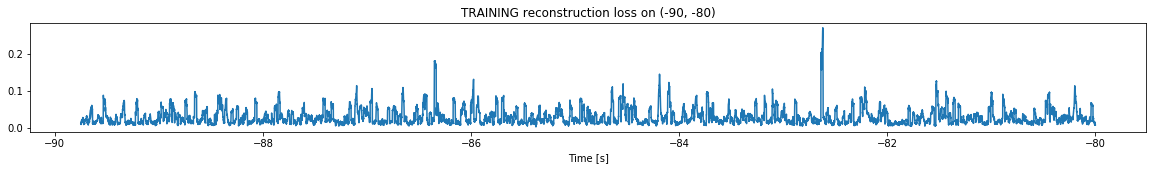

Finished training, median of the log(loss) is:  -1.648858676492242
Triggering for section:  (-80, 0)
Using this median for triggering: -1.648858676492242


In [3]:
X_test, X_pred_test, time_test = simulation("./data/Ramp4/", 10, (-90,0))

In [11]:
X_pred_test

array([[ 1.37358606e-01,  1.55057907e-01,  1.78665072e-01, ...,
         1.06935360e-01,  1.16997592e-01,  6.30865432e-03],
       [ 1.42010108e-01,  1.63649917e-01,  1.87867194e-01, ...,
         1.07666336e-01,  1.21215560e-01,  7.84172677e-03],
       [ 1.40534282e-01,  1.63301140e-01,  1.86753899e-01, ...,
         1.06860518e-01,  1.19449116e-01,  7.57367536e-03],
       ...,
       [-1.26264885e+02,  1.19935822e+02, -1.42589502e+01, ...,
        -7.97816086e+01, -1.21933956e+01, -1.98152866e+01],
       [-1.41612854e+02,  1.34198990e+02, -1.60846863e+01, ...,
        -8.91965866e+01, -1.36146832e+01, -2.21236591e+01],
       [-2.09526932e+02,  1.97312790e+02, -2.41635475e+01, ...,
        -1.30857361e+02, -1.99037457e+01, -3.23380966e+01]], dtype=float32)

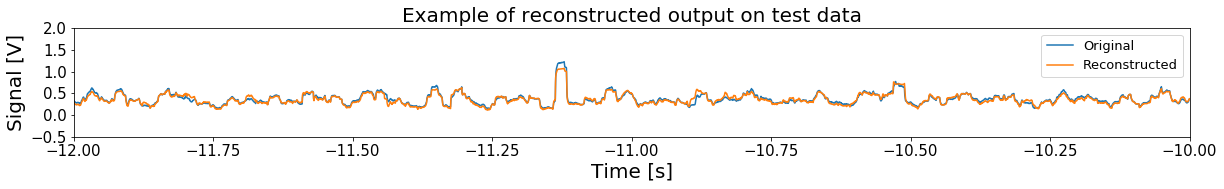

In [32]:
plt.figure(figsize=(20,2))
plt.plot(time_test, X_test[:,3], label = 'Original')
plt.plot(time_test, X_pred_test[:,3], label = 'Reconstructed')
plt.title("Example of reconstructed output on test data", fontsize = 20)
plt.xlabel("Time [s]", fontsize = 20)
plt.ylabel("Signal [V]", fontsize = 20)
plt.xlim([-12,-10])
plt.ylim([-0.5,2])
plt.legend(loc = 'best', fontsize = 13)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig('./figures/reconstructed_example.pdf', bbox_inches = 'tight')

In [33]:
!pwd

/uscms_data/d3/dhoang/quench-detector
